# Speech Emotion Recognition

## I. Context
In this project I build a prevision model using deep learning combining **CNN**  and  **LSTM**  to detect a person’s emotions (HAPPY, SAD, FEAR, ANGRY, DISGUST, SURPRISE, NEUTRAL) just by their voice. 

### Audio features:
- **Log-mel-spectrogram**: the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency


### Data:
- **RAVDESS**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes *calm*, *happy*, *sad*, *angry*, *fearful*, *surprise*, and *disgust* expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. (https://zenodo.org/record/1188976#.XA48aC17Q1J)

## II. General Imports

In [131]:
### General imports ###
import os
from glob import glob
import pickle
import numpy as np

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder

# Ensure np_utils functionality is included
from tensorflow.keras.utils import to_categorical as np_utils_to_categorical


### Warning ###
import warnings
warnings.filterwarnings('ignore')

## III. Import datas

In [132]:
# RAVDESS mel-Spectrogram
X_train = pickle.load(open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

## IV. Encode label

In [133]:
len(y_test)

453

In [134]:
# Encode Label from categorical to numerical
lb = LabelEncoder()
y_train = np_utils_to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils_to_categorical(lb.transform(np.ravel(y_test)))

In [135]:
X_train.shape, X_test.shape

((5430, 5, 128, 128), (453, 5, 128, 128))

In [136]:
y_test.shape

(453, 7)

## V. Reshape train and test set

In [137]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [138]:
X_train.shape, X_test.shape

((5430, 5, 128, 128, 1), (453, 5, 128, 128, 1))

## VI. Time Distributed ConvNet model

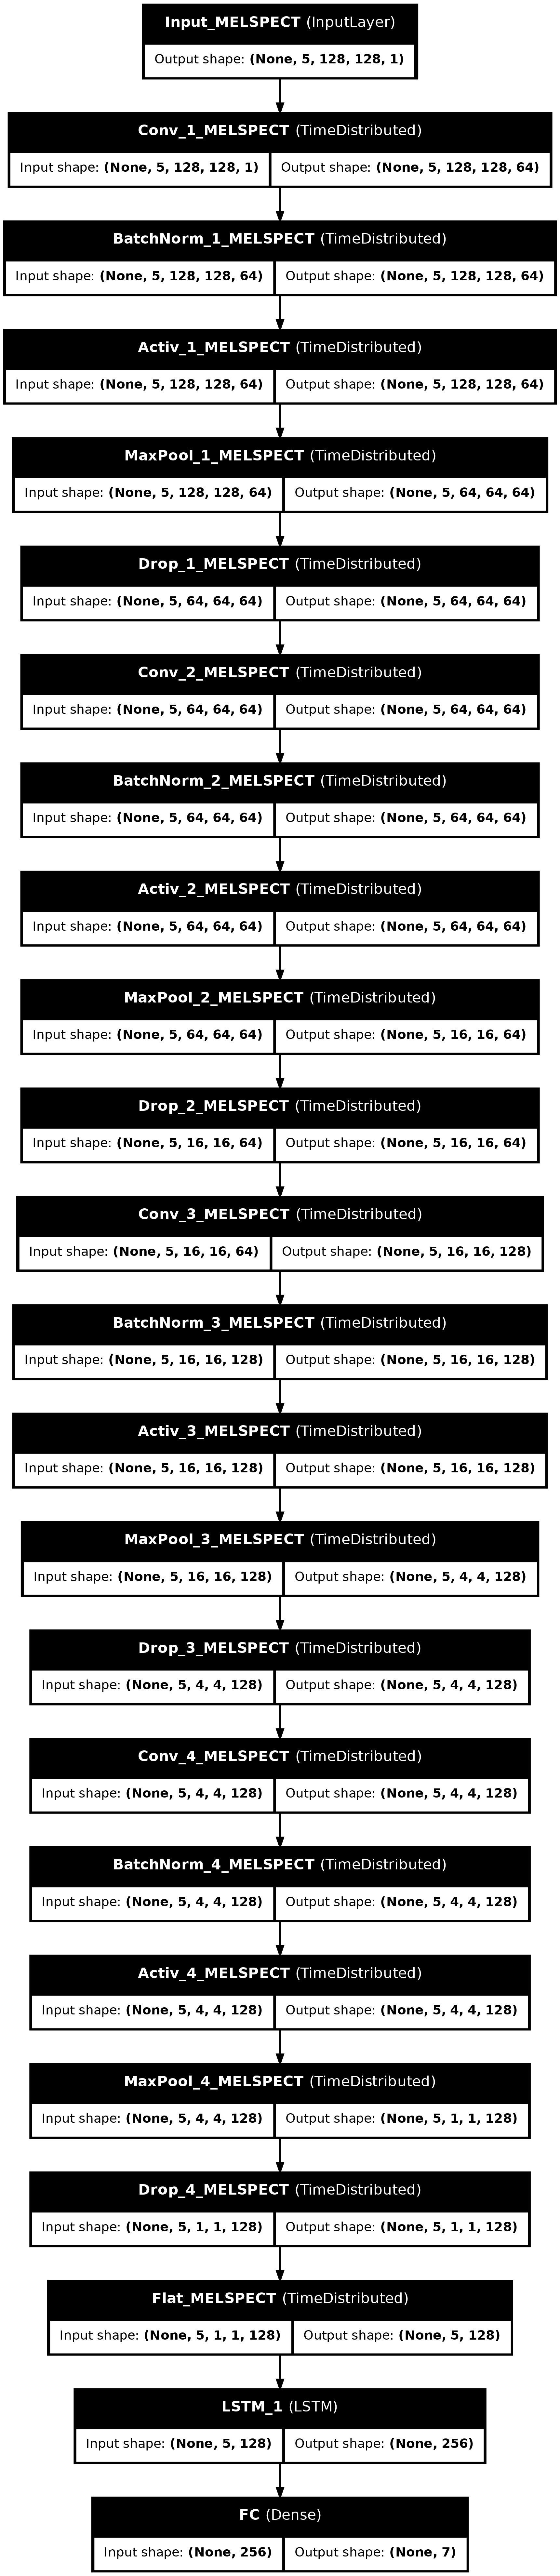

In [139]:
K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [13]:
# Compile model
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/SpeechEmotionRecognition [CNN-LSTM]Model.keras', save_best_only=True, monitor='val_acc', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 802s 9s/step - accuracy: 0.1744 - loss: 1.9434 - val_accuracy: 0.1943 - val_loss: 1.9257
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 817s 10s/step - accuracy: 0.2363 - loss: 1.8067 - val_accuracy: 0.2097 - val_loss: 1.8823
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 806s 9s/step - accuracy: 0.2932 - loss: 1.7046 - val_accuracy: 0.2693 - val_loss: 1.7759
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 759s 9s/step - accuracy: 0.3366 - loss: 1.6043 - val_accuracy: 0.3157 - val_loss: 1.6891
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 773s 9s/step - accuracy: 0.3612 - loss: 1.5507 - val_accuracy: 0.3466 - val_loss: 1.6161
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 716s 8s/step - accuracy: 0.3900 - loss: 1.5185 - val_accuracy: 0.3466 - val_loss: 1.5643
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 749s 9s/step - accuracy: 0.3932 - loss: 1.4792 - val_accuracy: 0.3885 - val_loss: 1.4840
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 693s 8s/step - accuracy: 0.4061 - loss: 1.4475 - val_accuracy: 0

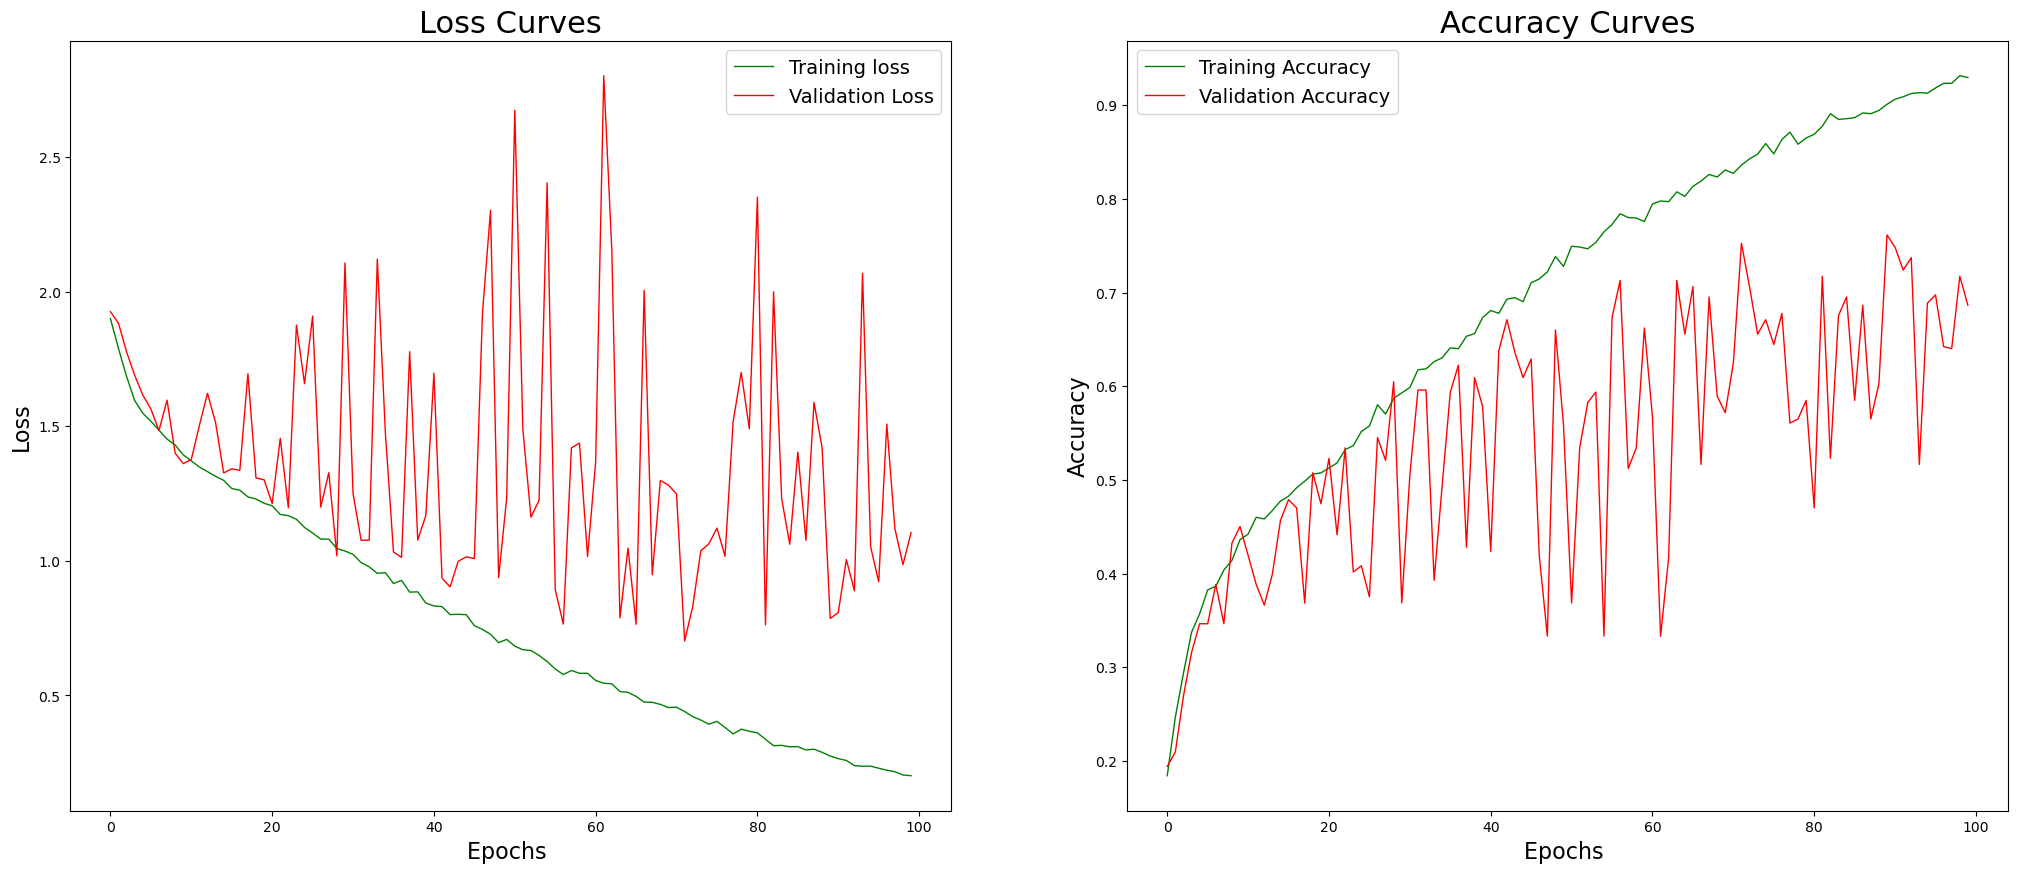

In [15]:
# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14) 
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)
 
# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],'-g',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

## VII. Save model

In [ ]:
model.save('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]M.h5')
model.save_weights('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]W.h5')

## VIII My Experiminets with the different optiomizer

Combination 3: Adam and Categorical Crossentropy

In [10]:
from tensorflow.keras.optimizers import Adam

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')
# Fit model                          
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1696s 20s/step - accuracy: 0.2212 - loss: 1.8671 - val_accuracy: 0.3642 - val_loss: 1.5866
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2027s 24s/step - accuracy: 0.3656 - loss: 1.5305 - val_accuracy: 0.2826 - val_loss: 1.8187
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2195s 26s/step - accuracy: 0.4234 - loss: 1.4137 - val_accuracy: 0.4084 - val_loss: 1.4532
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2481s 29s/step - accuracy: 0.4534 - loss: 1.3256 - val_accuracy: 0.4216 - val_loss: 1.3281
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2530s 30s/step - accuracy: 0.5070 - loss: 1.2148 - val_accuracy: 0.4901 - val_loss: 1.2298
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2067s 24s/step - accuracy: 0.5511 - loss: 1.1246 - val_accuracy: 0.4216 - val_loss: 1.6872
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1576s 19s/step - accuracy: 0.5728 - loss: 1.0718 - val_accuracy: 0.4260 - val_loss: 1.5238
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1572s 19s/step - accuracy: 0.6288 - loss: 0.9853 - 

# Running the model from 20 to 100 epoch since the server is diconnected at epoch 19.

In [140]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
# Load the best saved model
model = load_model('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras')

# Compile the model again (not necessary but good practice)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model starting from epoch 19
initial_epoch = 19
history = model.fit(X_train, y_train, batch_size=64, epochs=100, initial_epoch=initial_epoch, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])


Epoch 20/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1505s 18s/step - accuracy: 0.8594 - loss: 0.3680 - val_accuracy: 0.5607 - val_loss: 1.5976
Epoch 21/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1855s 22s/step - accuracy: 0.8852 - loss: 0.3145 - val_accuracy: 0.6093 - val_loss: 1.5044
Epoch 22/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1834s 21s/step - accuracy: 0.8835 - loss: 0.3182 - val_accuracy: 0.6490 - val_loss: 1.1354
Epoch 23/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1837s 21s/step - accuracy: 0.9130 - loss: 0.2586 - val_accuracy: 0.7506 - val_loss: 0.8393
Epoch 24/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1853s 22s/step - accuracy: 0.9049 - loss: 0.2556 - val_accuracy: 0.6954 - val_loss: 1.0117
Epoch 25/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1951s 23s/step - accuracy: 0.9081 - loss: 0.2516 - val_accuracy: 0.6733 - val_loss: 1.0060
Epoch 26/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1890s 22s/step - accuracy: 0.9293 - loss: 0.2179 - val_accuracy: 0.6777 - val_loss: 1.1165
Epoch 27/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1803s 21s/step - accuracy: 0.9253 - loss: 0

In [10]:
# Load the best saved model
model = load_model('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras')

# Compile the model again (not necessary but good practice)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model starting from epoch 19
initial_epoch = 65
history = model.fit(X_train, y_train, batch_size=64, epochs=100, initial_epoch=initial_epoch, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])


Epoch 66/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2665s 31s/step - accuracy: 0.9744 - loss: 0.0671 - val_accuracy: 0.7506 - val_loss: 1.0846
Epoch 67/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2613s 31s/step - accuracy: 0.9805 - loss: 0.0509 - val_accuracy: 0.5629 - val_loss: 2.0722
Epoch 68/100
25/85 ━━━━━━━━━━━━━━━━━━━━ 30:17 30s/step - accuracy: 0.9802 - loss: 0.0615

In [9]:
# Load the best saved model
model = load_model('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras')

# Compile the model again (not necessary but good practice)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model starting from epoch 19
initial_epoch = 69
history = model.fit(X_train, y_train, batch_size=64, epochs=100, initial_epoch=initial_epoch, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])


Epoch 70/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2727s 32s/step - accuracy: 0.9786 - loss: 0.0584 - val_accuracy: 0.7903 - val_loss: 0.9017
Epoch 71/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2587s 30s/step - accuracy: 0.9837 - loss: 0.0493 - val_accuracy: 0.7660 - val_loss: 0.9748
Epoch 72/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2475s 29s/step - accuracy: 0.9861 - loss: 0.0464 - val_accuracy: 0.6667 - val_loss: 1.7656
Epoch 73/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1516s 18s/step - accuracy: 0.9840 - loss: 0.0577 - val_accuracy: 0.7528 - val_loss: 1.0305
Epoch 74/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1536s 18s/step - accuracy: 0.9840 - loss: 0.0453 - val_accuracy: 0.7483 - val_loss: 1.2527
Epoch 75/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1524s 18s/step - accuracy: 0.9831 - loss: 0.0489 - val_accuracy: 0.7461 - val_loss: 1.0574
Epoch 76/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1510s 17s/step - accuracy: 0.9831 - loss: 0.0480 - val_accuracy: 0.7682 - val_loss: 1.0695
Epoch 77/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1526s 18s/step - accuracy: 0.9847 - loss: 0

In [35]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the best saved model
model_path = '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[CNN-LSTM]Model_Adam_CategoricalCrossentropy.keras'
model = load_model(model_path)

# Prepare your new data (ensure it's preprocessed appropriately)
# X_new = preprocess_function(raw_data)

# Predict using the loaded model
predictions = model.predict(X_test)

# Get the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Display predictions
print("Predicted classes:", predicted_classes)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step
Predicted classes: [5 4 1 2 5 2 4 1 0 5 2 1 2 3 3 2 2 5 2 2 0 5 1 1 1 2 5 2 3 2 3 3 3 2 4 2 2
 4 2 2 2 1 2 2 2 1 3 2 2 2 2 4 5 2 1 1 2 1 2 2 2 2 3 1 2 2 1 2 3 1 2 2 2 2
 2 2 4 2 2 4 2 1 1 4 4 2 1 1 3 1 2 2 1 4 1 5 2 2 5 0 2 1 1 2 2 3 1 3 5 2 2
 2 1 2 1 1 1 2 4 2 0 2 2 1 2 1 2 4 2 3 3 1 5 2 2 2 4 3 0 2 2 1 2 2 1 2 1 2
 2 3 2 3 2 3 5 3 2 2 4 2 1 2 3 3 2 4 2 2 2 3 1 0 3 4 5 3 1 2 2 1 1 3 1 1 1
 2 5 2 5 5 2 5 1 3 2 1 1 4 2 5 2 1 2 2 2 3 2 2 5 4 4 2 1 1 2 1 3 1 1 2 1 1
 3 3 4 1 4 1 2 2 3 2 3 3 4 1 0 5 0 2 2 2 1 2 2 5 4 2 2 2 2 1 1 4 1 3 1 2 2
 0 2 2 1 2 2 1 2 4 2 5 0 2 2 2 1 5 2 4 2 2 2 1 1 2 5 2 5 2 0 3 2 2 2 0 2 2
 2 1 2 1 2 3 5 1 5 2 0 2 4 2 2 3 4 4 4 2 3 3 2 2 5 4 4 2 2 2 0 1 3 5 2 3 0
 2 2 2 2 2 2 3 1 2 5 4 2 1 5 2 2 2 2 0 0 3 1 2 2 2 2 3 5 5 1 1 5 4 2 3 2 3
 0 0 5 2 2 4 1 1 0 1 1 3 3 4 2 5 2 4 2 2 3 4 4 2 2 2 2 2 2 3 2 1 2 2 2 2 1
 1 1 0 1 1 3 3 1 2 3 2 2 1 2 2 2 3 5 1 1 2 3 1 2 2 2 0 3 3 2 0 3 2 2 2 1 3
 2 2 4 4 3 5 6 3 3]


In [28]:
y_test.shape

(453, 7)

In [30]:
y_test1 = []
for i in range(453):
    for j in range(7):
        if y_test[i, j] == 1:
            y_test1.append(j)

In [37]:
from sklearn.metrics import accuracy_score

# Assuming y_true is your true labels and predicted_classes are obtained from the model
accuracy = accuracy_score(y_test1, predicted_classes)

print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.48


RMSprop and Categorical Crossentropy

In [142]:
from tensorflow.keras.optimizers import RMSprop

# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/SpeechEmotionRecognition [CNN-LSTM]Model_RMSprop_CategoricalCrossentropy.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 651s 8s/step - accuracy: 0.2224 - loss: 1.9109 - val_accuracy: 0.2759 - val_loss: 1.8297
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 654s 8s/step - accuracy: 0.3684 - loss: 1.5240 - val_accuracy: 0.4194 - val_loss: 1.4895
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 657s 8s/step - accuracy: 0.4423 - loss: 1.3775 - val_accuracy: 0.3245 - val_loss: 1.8579
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 643s 8s/step - accuracy: 0.4776 - loss: 1.2791 - val_accuracy: 0.4636 - val_loss: 1.2914
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 641s 8s/step - accuracy: 0.5278 - loss: 1.1981 - val_accuracy: 0.5298 - val_loss: 1.1732
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 647s 8s/step - accuracy: 0.5470 - loss: 1.1399 - val_accuracy: 0.5806 - val_loss: 1.0892
Epoch 7/10
71/85 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - accuracy: 0.5774 - loss: 1.0797